# Filtering by continuous wavelet transform

Continuous wavelet transform can advantageously be applied besides signal analysis to signal **filtering**.

We have already analyzed seasonally averaged sea surface temperature [data](http://paos.colorado.edu/research/wavelets/wave_python/sst_nino3.dat) that are free of a cycle of one year. Let us use the same data [sst_nino3.dat](http://paos.colorado.edu/research/wavelets/wave_python/sst_nino3.dat) for filtering. 

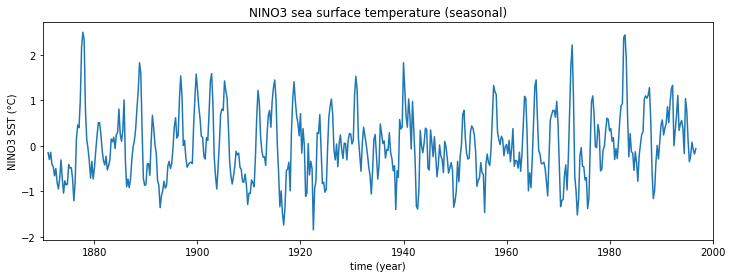

In [1]:
import numpy as np
from waveletFunctions import wavelet, wave_signif
import matplotlib.pyplot as plt

sst = np.loadtxt('sst_nino3.dat')
n = len(sst)
dt = 0.25
time = np.arange(len(sst)) * dt + 1871.0  # time epochs
xlim = ([1870, 2000])


%matplotlib inline
plt.figure(figsize=(12, 4))
plt.plot(time, sst)
plt.xlim(xlim[:])
plt.xlabel('time (year)')
plt.ylabel('NINO3 SST (°C)')
plt.title('NINO3 sea surface temperature (seasonal)')
plt.show()

Let us filter this signal such that we keep components with periods between 2-8 years.

Let us use again the function of the inverse wavelet transform which has been written earlier.

In [2]:
def icwt(W, sj, dt, dj=1/8, mother='morlet'):
    """
    Inverse continuous wavelet transform.

    Parameters
    ----------
    W : wavelet transform
    sj : vector of scale indices
    dt : sampling interval
    dj : discrete scale interval, default 0.125.
    mother : mother wavelet (default: Morlet)
    
    Result
    --------
    iW : inverse wavelet transform
    """
    mother = mother.upper()
    if mother == 'MORLET':
        Cd = 0.7785  
        psi0 = 0.751126
    elif mother == 'PAUL': # Paul, m=4
        Cd = 1.132
        psi0 = 1.07894
    elif mother == 'DOG':   # Dog, m=2
        Cd = 3.541
        psi0 = 0.86733
    else:
        raise Error('Mother must be one of Morlet, Paul, DOG')

    a, b = W.shape
    c = sj.size
    if a == c:
        sj = (np.ones([b, 1]) * sj).transpose()
    elif b == c:
        sj = np.ones([a, 1]) * sj
    else:
        raise Warning('Input array dimensions do not match.')

    iW = dj * np.sqrt(dt) / (Cd * psi0) * (
        np.real(W) / np.sqrt(sj)).sum(axis=0)
    return iW

pad = 1  # zero padding (recommended)
dj = 0.125  # 8 sub-octaves (in one octave)
s0 = 2 * dt  # 6 month initial scale
j1 = 7 / dj  # 7 octaves
mother = 'MORLET'

Calculate CWT and determine corrected signal power, filter for 2-8 year periods and make reconstruction of the filtered signal with inverse CWT.

In [3]:
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother)
scale_ext = np.outer(scale,np.ones(n))
power = (np.abs(wave))**2 /scale_ext  # power spectrum (corrected)

# filtering for periods between 2-8 years
zmask = np.logical_or(scale_ext<2, scale_ext>=8) # zero here
power[zmask] = 0.0
wavethr = np.copy(wave)
wavethr[zmask] = 0.0

# reconstruction by inverse wavelet transform
x = icwt(wavethr, scale, dt, dj, 'morlet')

Plot wavelet map and filtered signal:

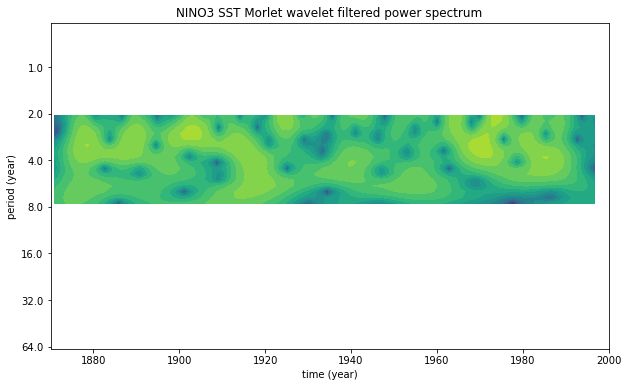

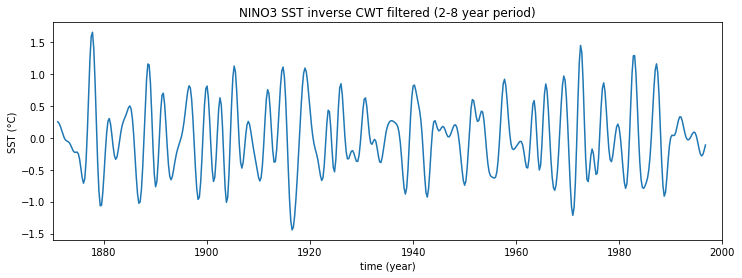

In [5]:
import matplotlib

plt.figure(figsize=(10, 6))
levels = np.array([2**i for i in range(-15,5)])
with np.errstate(divide='ignore'):
    CS = plt.contourf(time, period, np.log2(power), len(levels))  
    im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('time (year)')
plt.ylabel('period (year)')
plt.title('NINO3 SST Morlet wavelet filtered power spectrum')
plt.xlim(xlim[:])
plt.yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(time, x)
plt.xlim(xlim[:])
plt.xlabel('time (year)')
plt.ylabel('SST (°C)')
plt.title('NINO3 SST inverse CWT filtered (2-8 year period)')
plt.show()

## Filtering wheel accelerometry with CWT

We use bicycle mounted 3 axis accelerometer data provided by [Ákos Vinkó](http://www.epito.bme.hu/vinko-akos) that were spline [interpolated](aint.dat) to a uniform 0.01 s sampling rate.

First read and plot tangential and centrifugal accelerations $a_x$, $a_y$.

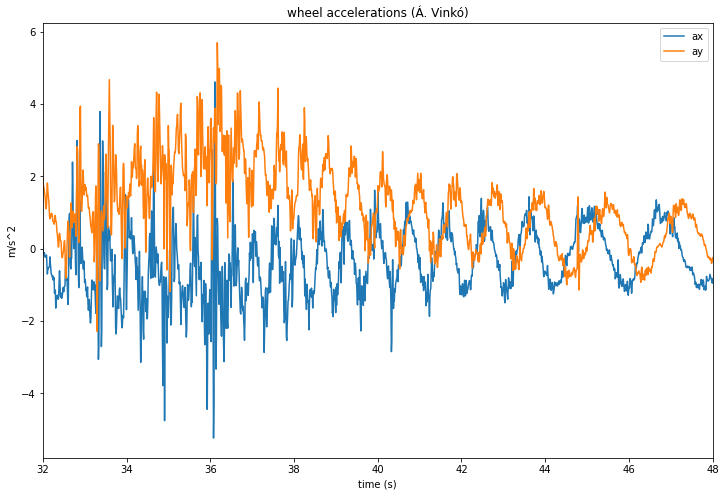

In [6]:
aint = np.loadtxt('aint.dat')
tint= aint[:,0]
axi = aint[:,1]
ayi = aint[:,2]
n = len(tint)
dt = 0.01

xlim = [32,48]
plt.figure(figsize=(12, 8))
plt.plot(tint, axi, label='ax')
plt.plot(tint, ayi, label='ay')
plt.xlim(xlim[:])
plt.xlabel('time (s)')
plt.ylabel('m/s^2')
plt.title('wheel accelerations (Á. Vinkó)')
plt.legend()
plt.show()

Calculate the continuous wavelet transform of acceleration data $a_x$ with Morlet wavelet:

In [7]:
pad = 1  
dj = 0.125 
s0 = 2*dt
j1 = 10/dj 
mother = 'MORLET'

wave, period, scale, coi = wavelet(axi,dt,pad,dj,s0,j1,mother)
# power spectrum (Compo)
power = (np.abs(wave)) ** 2 
# filtering by thresholding
pvar = np.std(power)**2  # signal variance
lvl = 0.15     # threshold (relative to signal variance)
thr = lvl*pvar
zmask = power <=thr # set zero here
powerthr = np.copy(power)
powerthr[zmask] = 0.0
wavethr = np.copy(wave)
wavethr[zmask] = 0.0

# reconstruction by inverse wavelet transform
axr = icwt(wavethr, scale, dt, dj, 'morlet')

Plot wavelet map of the tangential acceleration component:

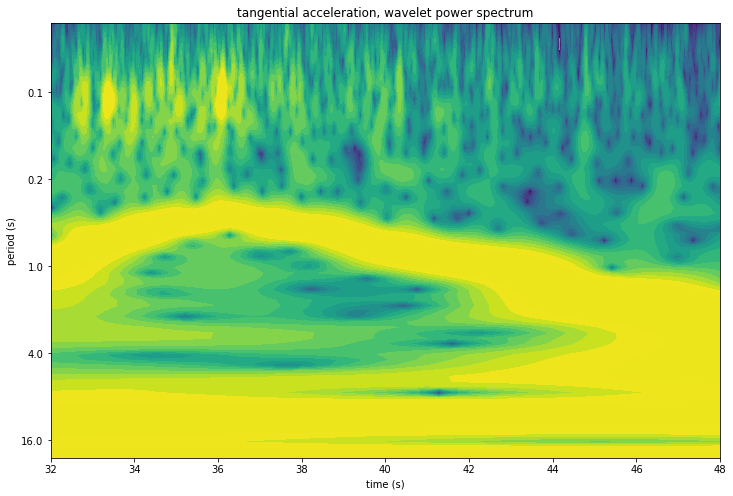

In [8]:
plt.figure(figsize=(12, 8))
levels = np.array([2**i for i in range(-15,5)])
CS = plt.contourf(tint, period, np.log2(power), len(levels))  
im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('time (s)')
plt.ylabel('period (s)')
plt.title('tangential acceleration, wavelet power spectrum')
plt.xlim(xlim[:])
plt.yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.show()

Plot filtered signal and its wavelet map:

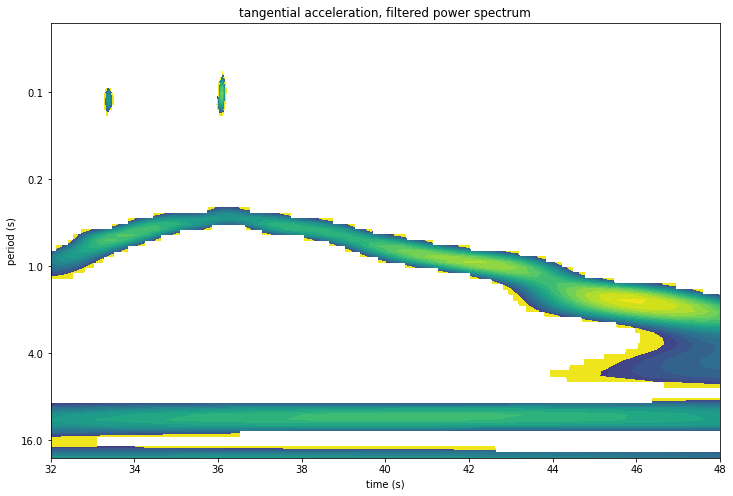

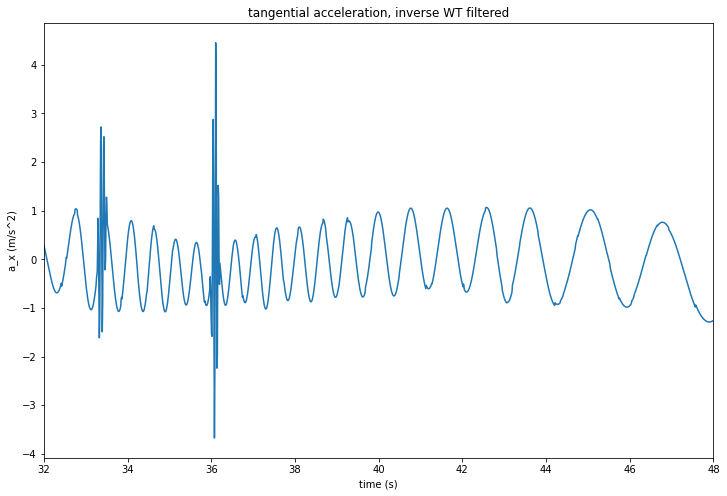

In [9]:
plt.figure(figsize=(12, 8))
levels = np.array([2**i for i in range(-15,5)])
with np.errstate(divide='ignore'):
    CS = plt.contourf(tint, period, np.log2(powerthr), len(levels))  
    im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('time (s)')
plt.ylabel('period (s)')
plt.title('tangential acceleration, filtered power spectrum')
plt.xlim(xlim[:])
plt.yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(tint, axr)
plt.xlim(xlim[:])
plt.xlabel('time (s)')
plt.ylabel('a_x (m/s^2)')
plt.title('tangential acceleration, inverse WT filtered')
plt.show()

Periodic acceleration transients at 33 s and 36 s are probably due to the slipping driven wheel. This is confirmed by zooming at these places:

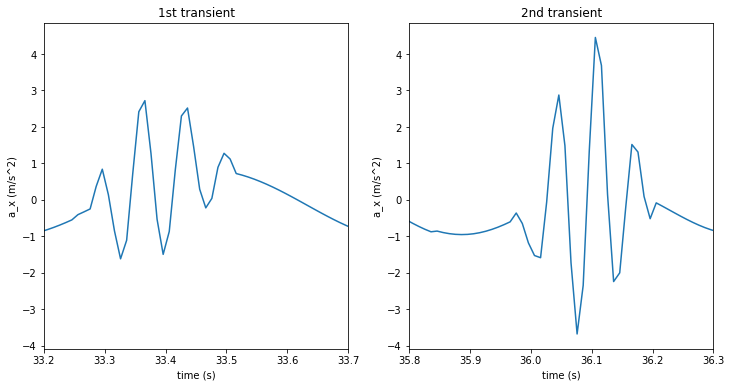

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(tint, axr)
plt.xlim([33.2,33.7])
plt.xlabel('time (s)')
plt.ylabel('a_x (m/s^2)')
plt.title('1st transient')
plt.subplot(122)
plt.plot(tint, axr)
plt.xlim([35.8,36.3])
plt.xlabel('time (s)')
plt.ylabel('a_x (m/s^2)')
plt.title('2nd transient')
plt.show()

### Significance test

The question may arise whether these signal transients are significant?

As we have already seen the answer requires a wavelet map based significance test. To proceed, 1- and 2-lag autocorrelations of the acceleration time series $a_x$ have to be estimated and averaged from the formula $\alpha=(\alpha_1 + \sqrt{\alpha_2})/2$.

In [11]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

acfx = autocorr(axi)

# average 1-lag autocorrelation
lag1,lag2 = acfx[1]/acfx[0], acfx[2]/acfx[0]
lag1m = (lag1 + np.sqrt(lag2))/2
print("average 1-lag autocorrelation: %.3f" % lag1m)

average 1-lag autocorrelation: 0.923


Now all data that are necessary for significance testing can be calculated.

In [12]:
# significance levels
signif = wave_signif(([1.0]), dt=dt, sigtest=0, scale=scale, lag1=0.923, mother='MORLET')
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
sig95 = power / sig95  # where > 1, power is significant

Replot wavelet map of acceleration data $a_x$ with contours related to the significance levels.

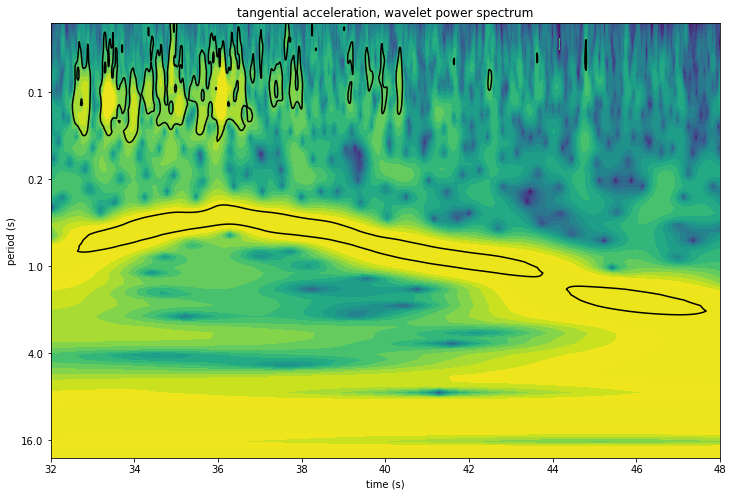

In [13]:
plt.figure(figsize=(12, 8))
levels = np.array([2**i for i in range(-15,5)])
CS = plt.contourf(tint, period, np.log2(power), len(levels))  
im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('time (s)')
plt.ylabel('period (s)')
plt.title('tangential acceleration, wavelet power spectrum')
plt.xlim(xlim[:])
plt.yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
# 95% significance level
plt.contour(tint, period, sig95, [-99, 1], colors='k')
plt.show()